# Lending Club Default Rate Analysis

# 3. Models 

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### 2015 Lending Club Data

In [2]:
## Load cleaned approved loan data
df_approved_2015 = pd.read_csv('approved_loan_2015_clean.csv',low_memory=False)

In [3]:
df_approved_2015.head(3)

,Unnamed: 0,loan_amnt,annual_inc,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,int_rate
0,0,16000.0,62000.0,720.0,724.0,4.0,227708.0,3.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,8.49
1,1,8000.0,45000.0,670.0,674.0,3.0,148154.0,2.0,11.0,0.0,...,0,0,0,0,0,0,0,0,0,10.78
2,2,10000.0,41600.0,695.0,699.0,2.0,168304.0,2.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,10.78


In [1]:
df_approved_2015.describe()

NameError: name 'df_approved_2015' is not defined

In [4]:
df2 = df_approved_2015.copy()
df2 = df2.ix[:,1:]

In [5]:
df2.shape

(419258, 77)

###  Split Training, Validation, and Test set

In [20]:
from sklearn.model_selection import train_test_split
# Split training(labeled) and test(unlabled) 
#df_train = df_bi[df_chin_bi['cuisine_Chinese'] != 2]
#df_test = df_chin_bi[df_chin_bi['Loan_status'] == 2]

# reduce data volumn by randomly selecting instances
np.random.seed(99)

ind = np.random.randint(0, len(df2), 100000)
df_reduced = df2.ix[ind, :]

df_labeled = df_reduced[df_reduced['Target']!=2]
df_unlabeled = df_reduced[df_reduced['Target']==2]

X = df_labeled.drop('Target',axis=1)
Y = df_labeled['Target']
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_vali , Y_train , Y_vali = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [21]:
X_train.shape

(19605, 76)

In [22]:
X_vali.shape

(6535, 76)

In [23]:
X_test.shape

(6535, 76)

## Logistic Regression

In [24]:
# panalty and C value tuning
# penalties = ['l1', 'l2'] ## found 'l1' always works better
C_values = sorted([np.exp(a*5) for a in np.linspace(-0.5,0.5,8)])
C_values

[0.0820849986238988,
 0.16767724875179707,
 0.34251885509304553,
 0.69967253737513024,
 1.4292400324179775,
 2.9195473041282605,
 5.9638383110653361,
 12.182493960703473]

In [26]:
# pick train test split ratio as 0.75

# LR GridSearch 1

# tuning hyper parameter
tuned_parameters_LR = {'C': C_values}    # 'penalty': penalties

lr = LogisticRegression(penalty='l1', random_state=22)
gr_lr = GridSearchCV(lr, param_grid=tuned_parameters_LR, cv=5, scoring="roc_auc")
gr_lr.fit(X_train, Y_train)

gr_lr_auc_scores = cross_val_score(gr_lr, X_train_val, Y_train_val, scoring="roc_auc", cv=5)

print ( "Logistic regression training size(0.75): Mean AUC %.4f\n" % (np.mean(gr_lr_auc_scores)))

print ("Best parameters set found:")
print (gr_lr.best_params_)
print("Gridsearch Scores: ")
print (gr_lr.score(X_vali, Y_vali))

means = gr_lr.cv_results_['mean_test_score']
stds = gr_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gr_lr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Logistic regression training size(0.75): Mean AUC 0.7163

Best parameters set found:
{'C': 0.0820849986238988}
Gridsearch Scores: 
0.713755503756
0.717 (+/-0.012) for {'C': 0.0820849986238988}
0.717 (+/-0.011) for {'C': 0.16767724875179707}
0.717 (+/-0.011) for {'C': 0.34251885509304553}
0.717 (+/-0.011) for {'C': 0.69967253737513024}
0.717 (+/-0.011) for {'C': 1.4292400324179775}
0.717 (+/-0.011) for {'C': 2.9195473041282605}
0.717 (+/-0.011) for {'C': 5.9638383110653361}
0.717 (+/-0.011) for {'C': 12.182493960703473}


In [27]:
gr_lr.best_params_

{'C': 0.0820849986238988}

In [28]:
## Optimal parameters

p_lr_opt = 'l1' ## found 'l1' always works better
c_lr_opt = gr_lr.best_params_['C']

## Decision Tree Classifier

In [29]:
mdepth_values = sorted([int(a) for a in np.linspace(6, 8, 3)])
print (mdepth_values)
mss_values = sorted([int(a) for a in np.linspace(400, 500, 4)])
print (mss_values)
msl_values = sorted([int(a) for a in np.linspace(50, 90, 4)])
print (msl_values)

[6, 7, 8]
[400, 433, 466, 500]
[50, 63, 76, 90]


In [30]:
# tuning hyperparameter
tuned_parameters_DT = {'max_depth': mdepth_values,
                       'min_samples_split': mss_values,
                       'min_samples_leaf':msl_values
                       }

dt = DecisionTreeClassifier(criterion='entropy', random_state=99)
gr_dt = GridSearchCV(dt, param_grid=tuned_parameters_DT, cv=5, scoring="roc_auc")
gr_dt.fit(X_train, Y_train)

gr_dt_auc_scores = cross_val_score(gr_dt, X_train_val, Y_train_val, scoring="roc_auc", cv=5)

print ( "Decision Tree with training size(0.75): Mean AUC %.4f\n" % (np.mean(gr_dt_auc_scores)))
## typo in printed reulst -- 0.75 instead of 0.7

print ("Best parameters set found:")
print (gr_dt.best_params_)
print("Gridsearch Scores: ")
print (gr_dt.score(X_vali, Y_vali))

means = gr_dt.cv_results_['mean_test_score']
stds = gr_dt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gr_dt.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Decision Tree with training size(0.7): Mean AUC 0.7016

Best parameters set found:
{'min_samples_leaf': 63, 'max_depth': 6, 'min_samples_split': 466}
Gridsearch Scores: 
0.694272155314
0.698 (+/-0.015) for {'min_samples_leaf': 50, 'max_depth': 6, 'min_samples_split': 400}
0.698 (+/-0.015) for {'min_samples_leaf': 50, 'max_depth': 6, 'min_samples_split': 433}
0.698 (+/-0.015) for {'min_samples_leaf': 50, 'max_depth': 6, 'min_samples_split': 466}
0.698 (+/-0.015) for {'min_samples_leaf': 50, 'max_depth': 6, 'min_samples_split': 500}
0.699 (+/-0.014) for {'min_samples_leaf': 63, 'max_depth': 6, 'min_samples_split': 400}
0.699 (+/-0.014) for {'min_samples_leaf': 63, 'max_depth': 6, 'min_samples_split': 433}
0.699 (+/-0.014) for {'min_samples_leaf': 63, 'max_depth': 6, 'min_samples_split': 466}
0.699 (+/-0.014) for {'min_samples_leaf': 63, 'max_depth': 6, 'min_samples_split': 500}
0.699 (+/-0.013) for {'min_samples_leaf': 76, 'max_depth': 6, 'min_samples_split': 400}
0.699 (+/-0.013) for {'

In [31]:
### Optimized decision tree parameters 
md_opt = gr_dt.best_params_['max_depth']
mss_opt = gr_dt.best_params_['min_samples_split']
msl_opt = gr_dt.best_params_['min_samples_leaf']


## SVM Classifier

In [32]:
X_train.head(2)

,loan_amnt,annual_inc,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,dti,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,int_rate
210635,30000.0,280000.0,745.0,749.0,4.0,206718.0,0.0,4.0,0.0,21.90,...,0,0,0,0,0,0,0,0,0,7.89
137428,20400.0,105000.0,665.0,669.0,6.0,225477.0,2.0,15.0,0.0,26.48,...,0,0,0,0,0,0,0,0,0,13.99


### Scaling selected columns(feature variables)

In [33]:
## Scale transforming
def scale_variables(df_X, columns=None):
    if columns:
        X_unchanged = df_X.loc[:, df_X.columns[~df_X.columns.isin(columns)]]
        
        if len(columns) == 1:
        # scale X
            scaler = preprocessing.StandardScaler().fit(df_X[columns[0]].values.reshape(-1,1))
            X_p = scaler.transform(df_X[columns[0]].values.reshape(-1,1))
            X_std = np.hstack((X_p, X_unchanged))

        else:
            scaler = preprocessing.StandardScaler().fit(df_X.loc[:, columns])
            X_p = scaler.transform(df_X.loc[:, columns])
            X_std = np.hstack((X_p, X_unchanged))
    else:
        scaler = preprocessing.StandardScaler().fit(df_X)
        X_std = scaler.transform(df_X)  
        
    return X_std

In [34]:
col_scale= ['loan_amnt', 'int_rate', 'annual_inc', 'fico_range_low', 'fico_range_high', \
            'num_actv_bc_tl','tot_cur_bal', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'dti' ]

In [35]:
X_train_std = scale_variables(X_train, columns=col_scale)
X_vali_std = scale_variables(X_vali, col_scale)
X_all_std = scale_variables(X_train_val, columns=col_scale)

In [36]:
X_train.shape

(19605, 76)

In [43]:
C_values_svc = sorted([np.exp(a*5) for a in np.linspace(0,1,6)])
C_values_svc

[1.0,
 2.7182818284590451,
 7.3890560989306504,
 20.085536923187675,
 54.598150033144236,
 148.4131591025766]

In [44]:
## Using LinearSVC ##
######################
# tuning hyperparameter

tuned_parameters_SVC = {'C': C_values_svc} 

svc = LinearSVC(random_state=99)
gr_svc = GridSearchCV(svc, param_grid=tuned_parameters_SVC, cv=5, scoring="roc_auc")
gr_svc.fit(X_train_std, Y_train)

gr_svc_auc_scores = cross_val_score(gr_svc, X_all_std, Y_train_val, scoring="roc_auc", cv=5)

print ( "SVM Classifier with training size(0.75): Mean AUC %.4f\n" % (np.mean(gr_svc_auc_scores)))

print ("Best parameters set found:")
print (gr_svc.best_params_)
print("Gridsearch Scores: ")
print (gr_svc.score(X_vali_std, Y_vali))

means = gr_svc.cv_results_['mean_test_score']
stds = gr_svc.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gr_svc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

SVM Classifier with training size(0.75): Mean AUC 0.7158

Best parameters set found:
{'C': 1.0}
Gridsearch Scores: 
0.712774324441
0.716 (+/-0.009) for {'C': 1.0}
0.716 (+/-0.009) for {'C': 2.7182818284590451}
0.716 (+/-0.008) for {'C': 7.3890560989306504}
0.700 (+/-0.023) for {'C': 20.085536923187675}
0.651 (+/-0.069) for {'C': 54.598150033144236}
0.597 (+/-0.110) for {'C': 148.4131591025766}


In [46]:
c_svc_opt = gr_svc.best_params_['C']

---------
## Compare Models: LR & DT & SVM
### Models with optimal parameters

In [47]:
models = []
labels = []

# fit LR model
lr_opt = LogisticRegression(C=c_lr_opt, penalty=p_lr_opt, random_state=99)
lr_opt.fit(X_train, Y_train)
models.append(lr_opt)
labels.append('Logistic Regression')

# fit DT model
dt_opt = DecisionTreeClassifier(criterion='entropy', random_state=99, \
                                max_depth=md_opt, min_samples_split=mss_opt, min_samples_leaf=msl_opt)
dt_opt.fit(X_train, Y_train)
models.append(dt_opt)
labels.append('Decision Tree')

# fit LinearSVM model
svm_opt = LinearSVC(penalty='l2', C=c_svc_opt, random_state=99)  ## how to use "rbf" ??
svm_opt.fit(X_train_std, Y_train)

svm_cali = CalibratedClassifierCV(base_estimator=svm_opt)  # for calculating probability
svm_cali.fit(X_train_std, Y_train)
models.append([svm_opt, svm_cali])
labels.append(['LinearSVC', 'SVM Calibrated Classifier'])

In [48]:
models

[LogisticRegression(C=0.0820849986238988, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=99,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=63,
             min_samples_split=466, min_weight_fraction_leaf=0.0,
             presort=False, random_state=99, splitter='best'),
 [LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
       multi_class='ovr', penalty='l2', random_state=99, tol=0.0001,
       verbose=0),
  CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    

In [57]:
## Reference: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

import matplotlib.pyplot as plt
%matplotlib inline

def plot_coefficients(classifier, label, feature_names, top_features=10):
    try:
        coef = classifier.coef_.ravel()
    except AttributeError:
        coef = classifier.feature_importances_
        pass
        
    top_positive_coefficients = np.argsort(coef)[-top_features:]   
    top_negative_coefficients = np.argsort(coef)[:top_features]
    if coef[top_negative_coefficients].min() != 0:
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    else:
        top_coefficients = top_positive_coefficients
        top_negative_coefficients = []
    
    # create plot
    plt.figure(figsize=(16, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + len(top_coefficients)), feature_names[top_coefficients], rotation=30, ha='right')
    plt.title('Top {} Important Features - {}'.format(top_features, label), size=20)
    plt.show()
    
    if len(top_negative_coefficients) != 0:
        df = pd.DataFrame(np.asarray([feature_names[top_positive_coefficients], coef[top_positive_coefficients],\
                           feature_names[top_negative_coefficients], coef[top_negative_coefficients]]).T, \
                          columns=['top_pos_features', 'top_pos_coef', 'top_neg_features', 'top_neg_coef'])
    else:
        df = pd.DataFrame(np.asarray([feature_names[top_positive_coefficients], coef[top_positive_coefficients]]).T,\
                          columns=['top_pos_features', 'top_pos_coef'])
    
    return label, df

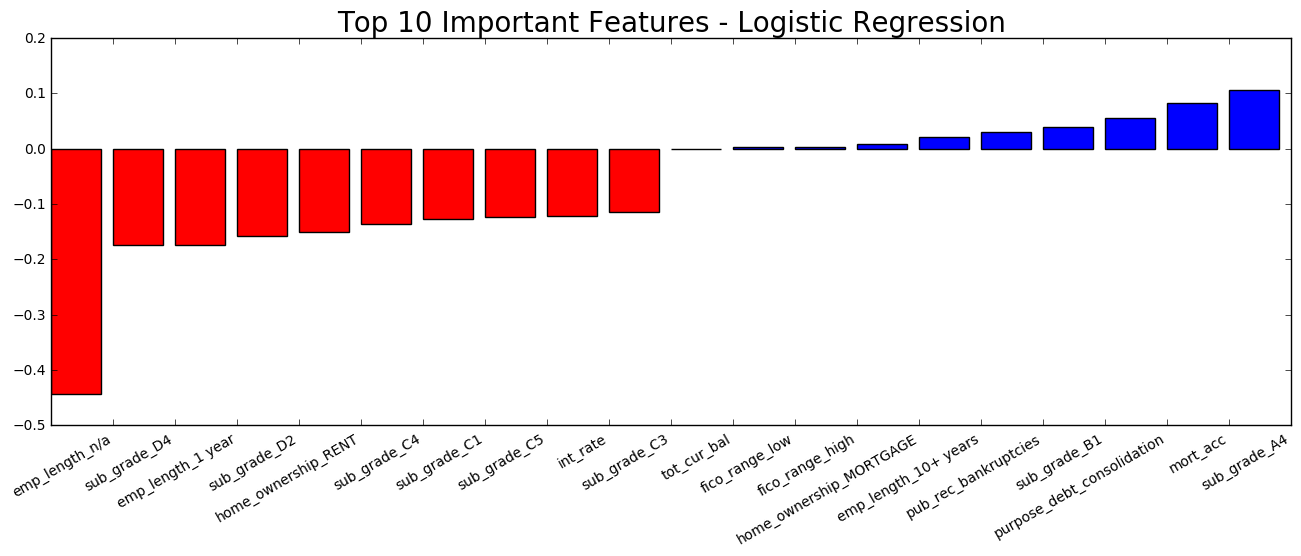

In [58]:
# plot top important features
label, df_lr_impfeatures = plot_coefficients(models[0], labels[0], X_train.columns.values)

In [59]:
print (label)
df_lr_impfeatures

Logistic Regression


,top_pos_features,top_pos_coef,top_neg_features,top_neg_coef
0,tot_cur_bal,1.04483e-06,emp_length_n/a,-0.444051
1,fico_range_low,0.00223135,sub_grade_D4,-0.174421
2,fico_range_high,0.00245894,emp_length_1 year,-0.173901
3,home_ownership_MORTGAGE,0.00853722,sub_grade_D2,-0.158492
4,emp_length_10+ years,0.0210682,home_ownership_RENT,-0.149736
5,pub_rec_bankruptcies,0.0302683,sub_grade_C4,-0.136969
6,sub_grade_B1,0.0391389,sub_grade_C1,-0.126201
7,purpose_debt_consolidation,0.0545033,sub_grade_C5,-0.122676
8,mort_acc,0.0825806,int_rate,-0.12152
9,sub_grade_A4,0.105295,sub_grade_C3,-0.11522


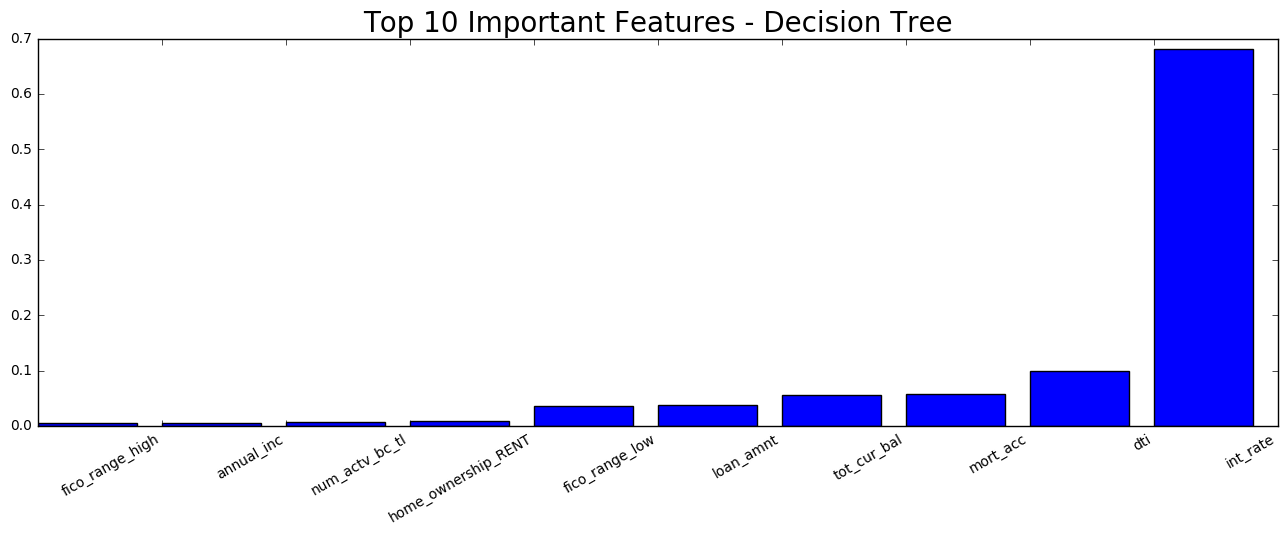

In [60]:
###### Decision Tree #######
label, df_dt_impfeatures = plot_coefficients(models[1], labels[1], X_train.columns.values)

In [61]:
print (label)
df_dt_impfeatures

Decision Tree


,top_pos_features,top_pos_coef
0,fico_range_high,0.00507156
1,annual_inc,0.00524947
2,num_actv_bc_tl,0.0078544
3,home_ownership_RENT,0.00953281
4,fico_range_low,0.0361827
5,loan_amnt,0.0374582
6,tot_cur_bal,0.0561557
7,mort_acc,0.0573905
8,dti,0.0997074
9,int_rate,0.68131


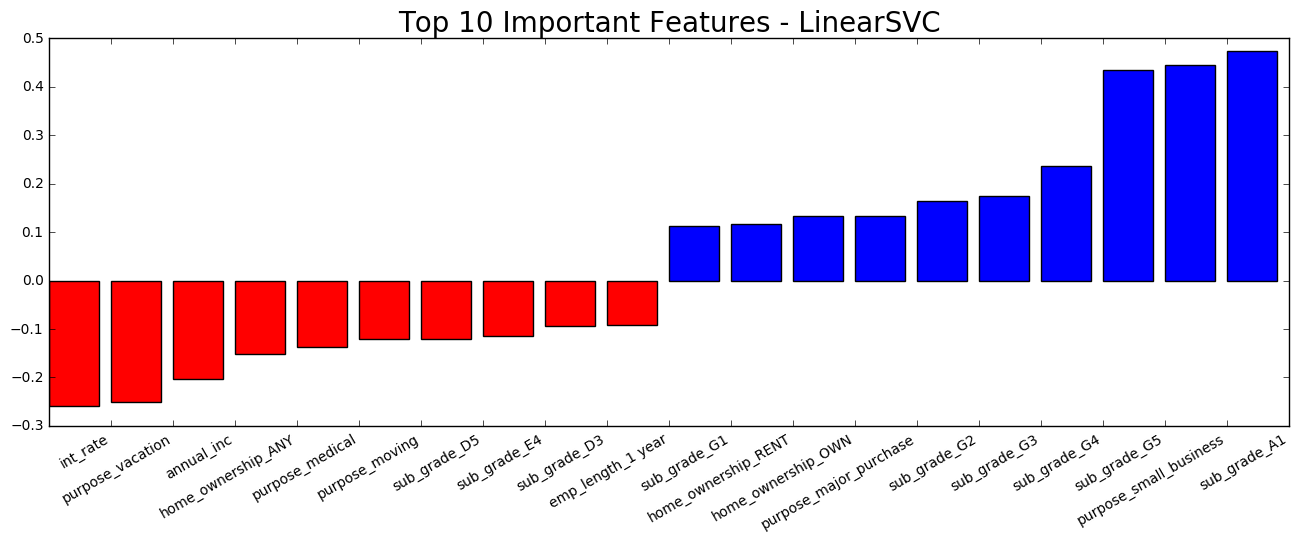

In [62]:
###### SVM #########
label, df_svc_impfeatures = plot_coefficients(models[2][0], labels[2][0], X_train.columns.values)

In [63]:
print (label)
df_svc_impfeatures

LinearSVC


,top_pos_features,top_pos_coef,top_neg_features,top_neg_coef
0,sub_grade_G1,0.112765,int_rate,-0.258702
1,home_ownership_RENT,0.117451,purpose_vacation,-0.251656
2,home_ownership_OWN,0.133327,annual_inc,-0.202906
3,purpose_major_purchase,0.133929,home_ownership_ANY,-0.152046
4,sub_grade_G2,0.163507,purpose_medical,-0.13798
5,sub_grade_G3,0.173919,purpose_moving,-0.121296
6,sub_grade_G4,0.235459,sub_grade_D5,-0.120179
7,sub_grade_G5,0.434612,sub_grade_E4,-0.114152
8,purpose_small_business,0.444603,sub_grade_D3,-0.0931256
9,sub_grade_A1,0.47373,emp_length_1 year,-0.0908406


## AUC Score - ROC Curves

In [64]:
models_roc = [models[0],models[1],models[2][1]]
labels_roc = [labels[0],labels[1],labels[2][1]]

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

#### Plot One model - train & validation sets ####
def plot_ROC(model, Y_train, X_train, Y_vali, X_vali, label, testset='Validation'):
    print ("AUC on the %s Train data = %.5f" % \
           (label, metrics.roc_auc_score(model.predict(X_train), Y_train)))
    print ("AUC on the %s %s data = %.5f\n" % \
           (label, testset, metrics.roc_auc_score(model.predict(X_vali), Y_vali)))

    #fpr, tpr, thresholds = metrics.roc_curve(Y_train, model.predict_proba(X_train)[:,1])    
    #plt.plot(fpr, tpr, label='{} Train set'.format(label))
    
    fpr, tpr, thresholds = metrics.roc_curve(Y_vali, model.predict_proba(X_vali)[:,1])    
    plt.plot(fpr, tpr, label='AUC-ROC for {} model'.format(label))
    
    plt.xlabel("false-positive rate", size=15)
    plt.ylabel("true-positibe rate", size=15)
    plt.title("ROC Curve of {} Model on {} sets".format(label, testset), size=16)
    plt.legend(loc='best')

    
##### more than one model - validation sets #####
def plot_ROCs(models, Y_trains, X_trains, Y_valis, X_valis, labels, testset='Validation'):  
    for model, Y_train, X_train, Y_vali, X_vali, label in \
    zip(models, Y_trains, X_trains, Y_valis, X_valis, labels):
        
        print ("AUC on the %s Train data = %.5f" % \
               (label, metrics.roc_auc_score(model.predict(X_train), Y_train)))
        print ("AUC on the %s %s data = %.5f\n" % \
               (label, testset, metrics.roc_auc_score(model.predict(X_vali), Y_vali)))
        
        fpr, tpr, thresholds = metrics.roc_curve(Y_vali, model.predict_proba(X_vali)[:,1])
        plt.plot(fpr, tpr, label='AUC-ROC for {} model'.format(label))
    
    plt.xlabel("fpr", size=15)
    plt.ylabel("tpr", size=15)
    plt.title("ROC Curves for Models and {} sets".format(testset), size=16)
    plt.legend(loc='best')


AUC on the Logistic Regression Train data = 0.66208
AUC on the Logistic Regression Validation data = 0.65283

AUC on the Decision Tree Train data = 0.65557
AUC on the Decision Tree Validation data = 0.64651

AUC on the SVM Calibrated Classifier Train data = 0.65939
AUC on the SVM Calibrated Classifier Validation data = 0.64888



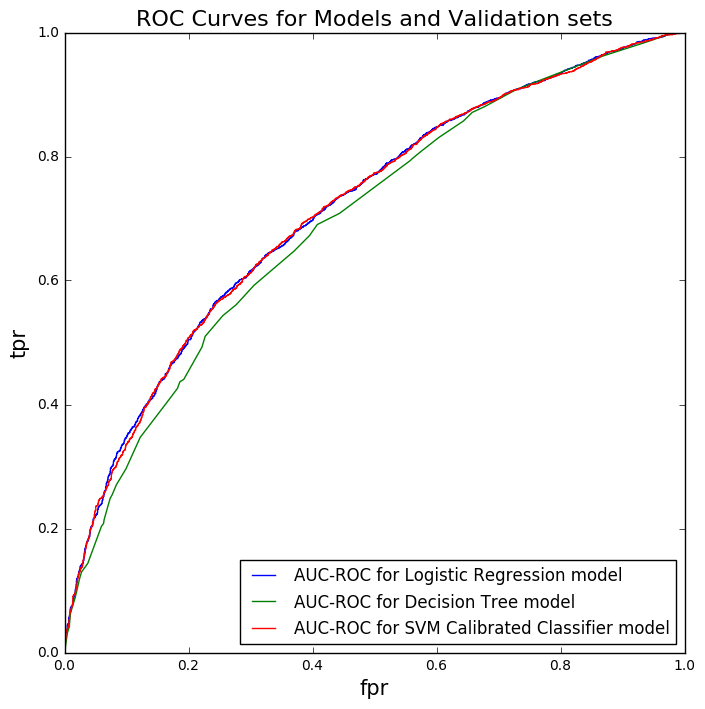

In [93]:
# Plot AUC for DT, LR, SVC optimal models
plot_ROCs(models_roc, [Y_train]*3, [X_train]*2+[X_train_std], [Y_vali]*3, [X_vali]*2+[X_vali_std], labels_roc)

In [94]:
c_lr_opt

0.0820849986238988

### Optimal Model: 
#### Logistic Regression
#### C: 0.0820849986238988

### Test the optimal Model on Test Set 

AUC on the Logistic Regression Train data = 0.65977
AUC on the Logistic Regression Test data = 0.66293



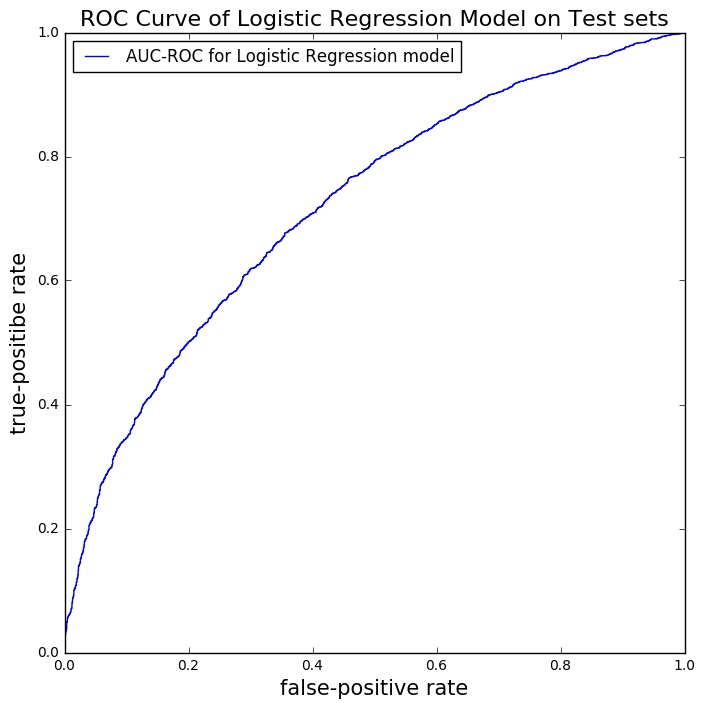

In [95]:
## Plot AUC for the optimal model
plot_ROC(models[0], Y_train_val, X_train_val, Y_test, X_test, labels[0], testset='Test')


### Test the model by picking more data

In [96]:
# reduce data volumn by randomly selecting instances
np.random.seed(55)

ind = np.random.randint(0, len(df2), 100000)
df_reduced = df2.ix[ind, :]

df_labeled = df_reduced[df_reduced['Target']!=2]
df_unlabeled = df_reduced[df_reduced['Target']==2]

X2 = df_labeled.drop('Target',axis=1)
Y2 = df_labeled['Target']

X_train_val2, X_test2, Y_train_val2, Y_test2 = train_test_split(X2, Y2, test_size=0.6, random_state=42)

In [97]:
#X_train_std2 = scale_variables(X_train, columns=col_scale)
#X_vali_std2 = scale_variables(X_vali, col_scale)
X_all_std2 = scale_variables(X_train_val2, columns=col_scale)
X_test_std2 = scale_variables(X_test2, columns=col_scale)

AUC on the Logistic Regression Train data = 0.66892
AUC on the Logistic Regression Larger Test data = 0.66371

AUC on the Decision Tree Train data = 0.64462
AUC on the Decision Tree Larger Test data = 0.63855

AUC on the SVM Calibrated Classifier Train data = 0.66906
AUC on the SVM Calibrated Classifier Larger Test data = 0.66007



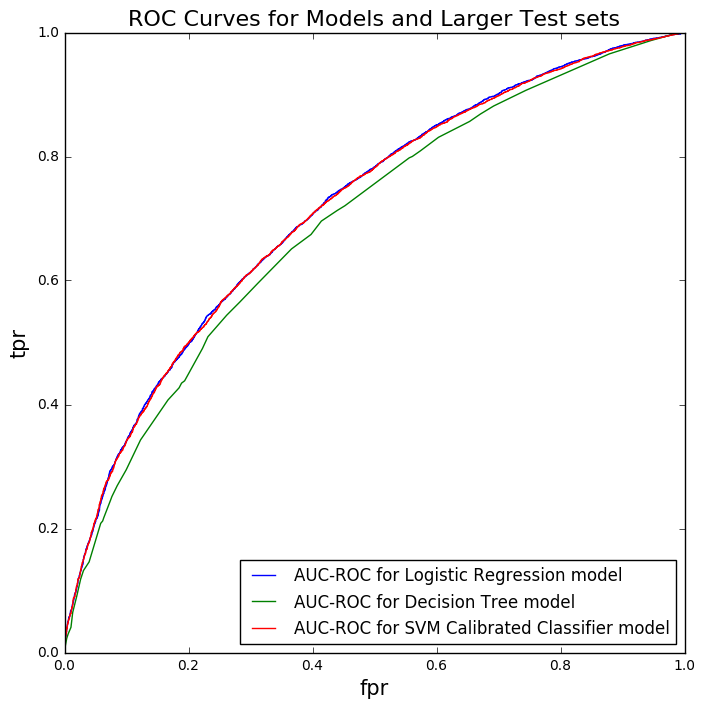

In [98]:
# Plot AUC for DT, LR, SVC optimal models
plot_ROCs(models_roc, [Y_train_val2]*3, [X_train_val2]*2+[X_all_std2],\
          [Y_test2]*3, [X_test2]*2+[X_test_std2], labels_roc, testset='Larger Test')

AUC on the Logistic Regression Train data = 0.66892
AUC on the Logistic Regression Larger Test data = 0.66371



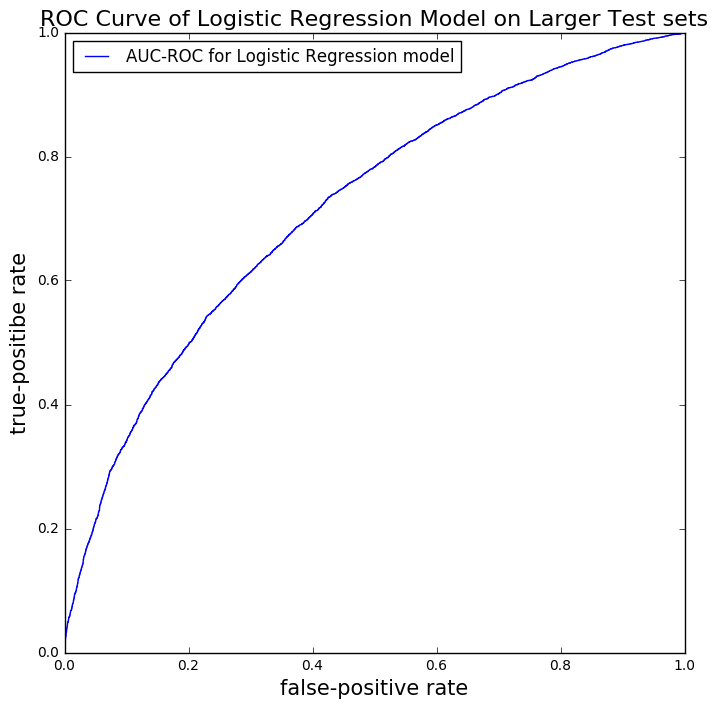

In [99]:
## Plot AUC for the optimal model with more training and test data
plot_ROC(models[0], Y_train_val2, X_train_val2, Y_test2, X_test2, labels[0], testset='Larger Test')